### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
t=-1

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb

In [3]:
#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',40)

### loading data

In [4]:
train_path = r"train.csv"
test_path = r"test.csv"

In [5]:
df = pd.read_csv(train_path,index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv(test_path,parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})
df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})

## Feature Engineering

##### based on the previous notebook (eda) we will consider the following 

- A) The Hourly cycle has a good correlation. [7am-18pm has the bigger share]
- B) The Temperature has good corr. [high is good except > ~ 27]
- C) The Functional Day has good corr. [functional is good for target]
- D) The Seasons has good corr. [hot season is better]

-------------

- E) The Visibility may prove to be good. [if encoded to very_low visibility vs normal visibiliy].
- F) The RainFall/SnowFall may prove to be good. [if encoded to Snowing / Raining or not].
- G) The Humidity may have something to investigate. [if encoded as 0-80 % normal rentals, 80-100% show sharp decay in rentals]

---------------
- H) the Dew point temperature is strongly corr to Temperature will drop it.
- I) the Solar Radiation may be discarded .. i didn't see good relation.
- J) the holidays didn't prove decisive saying on our target. maybe discarded too.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      5760 non-null   datetime64[ns]
 1   y                         5760 non-null   int64         
 2   Hour                      5760 non-null   int64         
 3   Temperature(C)            5760 non-null   float64       
 4   Humidity(%)               5760 non-null   int64         
 5   Wind speed (m/s)          5760 non-null   float64       
 6   Visibility (10m)          5760 non-null   int64         
 7   Dew point temperature(C)  5760 non-null   float64       
 8   Solar Radiation (MJ/m2)   5760 non-null   float64       
 9   Rainfall(mm)              5760 non-null   float64       
 10  Snowfall (cm)             5760 non-null   float64       
 11  Seasons                   5760 non-null   object        
 12  Holiday             

In [7]:
df.describe()

,y,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


In [8]:
df['Seasons'].value_counts()

Autumn    1440
Spring    1440
Summer    1440
Winter    1440
Name: Seasons, dtype: int64

In [9]:
df_prep = df.copy()

In [10]:
df_prep['Year'] = df['Date'].dt.year.astype('int')
df_prep['Week'] = df['Date'].dt.isocalendar().week.astype('int')
df_prep['Month'] = df['Date'].dt.month.astype('int')
df_prep['WeekDay'] = df['Date'].dt.weekday.astype('int')

In [11]:
def restore_data_series(dataframe,dforiginal,col_name):
    dataframe[col_name] = dforiginal[col_name]

In [12]:
def map_data_series(dataframe,col_name,from_vals,to_vals):
    dataframe[col_name].replace(from_vals,to_vals,inplace=True)

In [13]:
def new_feature_data_series(dataframe,col_name,function,new_col_name):
       dataframe[new_col_name]  = dataframe[col_name].apply(function,axis=1)

In [14]:
map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])

In [15]:
map_data_series(df_prep,'Holiday',['Holiday','No Holiday'],[1,0])

In [16]:
map_data_series(df_prep,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [17]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def rush_hour(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] in [6,7,8,9,10,16,17,18,19,20]):
        return 1
    else:
        return 0
    
def rush_hour_grad_2(df):
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day']

    return (np.exp(-abs(df['Hour'] - 8)) +  np.exp(-abs(df['Hour'] - 18))) * is_functional

def rush_hour_grad(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
    
def dead_hour_grad(df):
    dead_range_1 = 3 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 4) <= dead_range_1): 
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0
    
def dead_hour_grad_2(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0   
new_feature_data_series(df_prep,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')
new_feature_data_series(df_prep,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')

In [18]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def day_night(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] >=6 and df['Hour'] <=18):
        return 1
    else:
        return 0

new_feature_data_series(df_prep,['Hour'],day_night,'day_night')

In [19]:
new_feature_data_series(df_prep,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')

In [20]:
new_feature_data_series(df_prep,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [21]:
new_feature_data_series(df_prep,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)','Wind speed (m/s)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [22]:
#something is wrong in feels like equation
# def feels_like(df):
#     ### inputs temp & humidity , outputs feels like temp
#     ## equation heat_index = c1 + c2 T + c3 R + c4 TR + c5 T^2 + c6 R^2 +...
#     c1 = -8.78469475556
#     c2 = 1.61139411
#     c3 = 2.33854883889
#     c4 = -0.14611605
#     c5 = -0.012308094
#     c6 = -0.0164248277778
#     c7 = 0.002211732
#     c8 = 0.00072546
#     c9 = -0.000003582
#     T = df['Temperature(C)']
#     R = df['Humidity(%)']
#     is_functionalDay = df['Functioning Day']
#     HI = (c1) + (c2 * T) +( c3 * R) + (c4  * T * R )+ (c5 *( T**2 ))+ (c6 * (R**2)) + (c7 * (T**2) * R) + (c8 * T * (R**2)) + (c9 * (T**2) * (R**2))
#     #HI = c1 + (c2 * T) +( c3 * R )+ (c4  * T * R )+ (c5 * T**2 )
#     return HI 

#new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
def humidex(df):
    ### humidex
    ## eq H = Tair + 5/9 * [(6.11 * e^5417.7530 * (a-b)) - 10 ]
    Tair = df['Temperature(C)']
    Tdew = df['Dew point temperature(C)']
    is_functionalDay = df['Functioning Day']
    a = 1/273.16
    b = 1/(273.15 + Tdew)
    Humidex = Tair + (5/9) * (6.11 * np.exp(5417.7530 * (a-b)) -10)
    return Humidex  
new_feature_data_series(df_prep,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [23]:
df_prep['Ideal'] = df[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [24]:
df_prep["Ideal"].value_counts()

1    4548
0    1212
Name: Ideal, dtype: int64

In [25]:
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility,'Visibility_cat')

In [26]:
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [27]:
# for rainfall

def rain_fall(df):
    # 0:2.5 , 
    
    if df['Rainfall(mm)'] < 0.5 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [28]:
def snow_fall(df):
    # 0:2.5 , 
    
    if df['Snowfall (cm)'] == 0 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [29]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [30]:
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [31]:
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [32]:
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [33]:
df_prep['Weather_State'] =df_prep[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [34]:
Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']
length = len(Weather_Description_list)+1
Weather_Description_neumeric = [*range(1, length, 1)]

In [35]:
map_data_series(df_prep,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [36]:
new_feature_data_series(df_prep,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [37]:
new_feature_data_series(df_prep,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [38]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    

In [39]:
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0

In [40]:
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0


In [41]:
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

In [42]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0

In [43]:
df_prep['Sky_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 
                 else 5, axis = 1)

In [44]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0

In [45]:
df_prep['Temp_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [46]:
df_prep[["Temp_State"]].value_counts()

Temp_State
1             2396
2             1358
3             1004
4             1002
dtype: int64

In [47]:
new_feature_data_series(df_prep,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [48]:
df_prep["Date_tmp"] = df_prep['Date'].dt.to_period('M')
new_feature_df = pd.DataFrame(df_prep.groupby(['Date_tmp', 'Year'])['y'].mean()).sort_values(["Year"])
new_feature_df = pd.DataFrame(new_feature_df['y'].shift(+t))
new_feature_df.reset_index(inplace=True)
new_feature_df.rename(columns={'y':'Prev Month y'}, inplace=True)
new_feature_df.drop(['Year'], axis = 1, inplace =True)
new_feature_df.fillna(new_feature_df.mean(), inplace = True)

In [49]:
df_prep = pd.merge(df_prep, new_feature_df, on='Date_tmp', how='left')

In [50]:
df_prep["Temperature lag1"] = df_prep["Temperature(C)"].shift(+t)
df_prep["Temperature lag1"].fillna(0, inplace=True)




df_prep["Rainfall lag1"] = df_prep["Rainfall(mm)"].shift(+t)
df_prep["Rainfall lag1"].fillna(0, inplace=True)

df_prep["Visibility  lag1"] = df_prep["Visibility (10m)"].shift(+t)
df_prep["Visibility  lag1"].fillna(0, inplace=True)



df_prep["Wind speed lag1"] = df_prep["Wind speed (m/s)"].shift(+t)
df_prep["Wind speed lag1"].fillna(0, inplace=True)



df_prep["Weather_State lag1"] = df_prep["Weather_State"].shift(+t)
df_prep["Weather_State lag1"].fillna(0, inplace=True)



df_prep["Humidity lag1"] = df_prep["Humidity(%)"].shift(+t)
df_prep["Humidity lag1"].fillna(0, inplace=True)



df_prep["Humidity lag2"] = df_prep["Humidity(%)"].shift(+t-1)
df_prep["Humidity lag2"].fillna(0, inplace=True)

df_prep["Rainfall(mm) rolling"] =df_prep ["Rainfall(mm)"].rolling(2).sum()
df_prep["Rainfall(mm) rolling"].fillna(0, inplace=True)

df_prep["Wind speed (m/s) rolling"] =df_prep["Weather_State"].rolling(2).sum()
df_prep["Wind speed (m/s) rolling"].fillna(0, inplace=True)


df_prep["Rush_hour lag1"] = df_prep["Rush_hour"].shift(+t)
df_prep["Rush_hour lag1"].fillna(0, inplace=True)



df_prep["Dead_hour lag1"] = df_prep["Dead_hour"].shift(+t)
df_prep["Dead_hour lag1"].fillna(0, inplace=True)


df_prep["Ideal lag1"] = df_prep["Ideal"].shift(+t)
df_prep["Ideal lag1"].fillna(0, inplace=True)

df_prep["Ideal lag2"] = df_prep["Ideal"].shift(+t-1)
df_prep["Ideal lag2"].fillna(0, inplace=True)

df_prep["Rush_hour lag2"] = df_prep["Rush_hour"].shift(+t-1)
df_prep["Rush_hour lag2"].fillna(0, inplace=True)



df_prep["Dew point temperature(C) lag1"] = df_prep["Dew point temperature(C)"].shift(+t)
df_prep["Dew point temperature(C) lag1"].fillna(0, inplace=True)

In [51]:
df_prep.columns

Index(['Date', 'y', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay',
       'Rush_hour', 'Dead_hour', 'day_night', 'Humidity_high',
       'Temperature_high', 'Weather_bad', 'Humidex', 'Ideal', 'Visibility_cat',
       'Visibility_dist', 'Rain_cat', 'Snow_cat', 'Weather_State',
       'Weather_stat&visb_dist', 'Weather&visb', 'Sky_State', 'Temp_State',
       'GBL_Forecast', 'Date_tmp', 'Prev Month y', 'Temperature lag1',
       'Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
       'Weather_State lag1', 'Humidity lag1', 'Humidity lag2',
       'Rainfall(mm) rolling', 'Wind speed (m/s) rolling', 'Rush_hour lag1',
       'Dead_hour lag1', 'Ideal lag1', 'Ideal lag2', 'Rush_hour lag2',
       'Dew point temperature(C) lag1'],
      dtype='object')

In [52]:
df_prep.isna().sum()

Date                             0
y                                0
Hour                             0
Temperature(C)                   0
Humidity(%)                      0
Wind speed (m/s)                 0
Visibility (10m)                 0
Dew point temperature(C)         0
Solar Radiation (MJ/m2)          0
Rainfall(mm)                     0
Snowfall (cm)                    0
Seasons                          0
Holiday                          0
Functioning Day                  0
Year                             0
Week                             0
Month                            0
WeekDay                          0
Rush_hour                        0
Dead_hour                        0
day_night                        0
Humidity_high                    0
Temperature_high                 0
Weather_bad                      0
Humidex                          0
Ideal                            0
Visibility_cat                   0
Visibility_dist                  0
Rain_cat            

----
# Training The Model

####  Our Scoring Metric (RMSLE)

In [53]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

def NumPyRMSLE(y_true:list, y_pred:list) -> float:
    """
        The Root Mean Squared Log Error (RMSLE) metric using only NumPy
        N.B. This function is a lot slower than sklearn's implementation
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    n = len(y_true)
    msle = np.mean([(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

##### Selecting features and splitting (do this everytime you change the features! and want to do training)

In [54]:

selected_features = ['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',"Dew point temperature(C)",
                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
                     'Functioning Day','Rush_hour','Dead_hour','Weather_State',
                     'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast',
                     'Temperature lag1','Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
                     'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
                     'Dead_hour lag1', 'Ideal lag1',"Dew point temperature(C) lag1","Humidity lag2","Rush_hour lag2","Ideal lag2",
                    "Rainfall(mm) rolling","Wind speed (m/s) rolling"]


train = df_prep.copy()
train["y"] = np.log(df_prep["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state=42,shuffle=True,)

In [55]:
len(selected_features)

39

---
## XGB

In [56]:
prev_trainX = 0
prev_testX = 0

In [57]:
# mohey 
# XGB = xgb.XGBRegressor(n_estimators=2100,subsample=0.887
#                        ,colsample_bytree = 0.9,colsample_bylevel=0.9,
#                        learning_rate=0.056,n_jobs=-1,max_depth =3)
XGB = xgb.XGBRegressor(n_estimators=2000,subsample=0.888
                       ,colsample_bytree = 0.97,colsample_bylevel=0.82,
                       learning_rate=0.056,n_jobs=-1,max_depth =3)
XGB.fit(X_train, y_train)

y_pred_trainXGB = XGB.predict(X_train)   
y_pred_testXGB = XGB.predict(X_test)

rmsle_trainXGB =  rmsle(y_train, y_pred_trainXGB, True)
rmsle_testXGB  = rmsle(y_test, y_pred_testXGB, True)

print('(Train) RF RMSLE:',rmsle_trainXGB )
print('(Test) RF RMSLE:',rmsle_testXGB  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainX)
print('(Test) Prev RMSLE:', prev_testX)
prev_trainX = rmsle_trainXGB 
prev_testX = rmsle_testXGB 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainXGB) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testXGB) * 100,' %')


(Train) RF RMSLE: 0.10954694509914085
(Test) RF RMSLE: 0.22311100235095077
---------------------------------
(Train) Prev RMSLE: 0
(Test) Prev RMSLE: 0
---------------------------------
Training Score: 99.9081255102452  %
Test Score: 99.67518227062033  %


<Figure size 864x576 with 0 Axes>

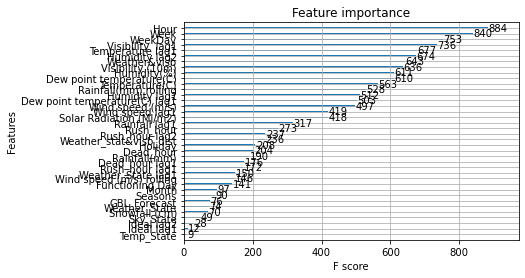

In [58]:
figure(figsize=(12, 8))
xgb.plot_importance(XGB)
plt.show()

In [59]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
cv_score = cross_val_score(XGB, X_train, y_train, n_jobs=4, verbose = 1, cv=kfold, scoring=rmsle_scorer)
print(f'cv_error : {-cv_score.mean()}')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


cv_error : 0.26099746475477337


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   14.6s finished


---
## GBRegressor

In [60]:
prev_trainGBR = 0
prev_testGBR = 0

In [61]:
#GBR learn_rate = 0.05 , n_est = 1000 

#GBR = GradientBoostingRegressor(random_state=0,loss='ls',
#    n_estimators=1000,subsample=0.7,learning_rate=0.05,
#    criterion='friedman_mse')


GBR = GradientBoostingRegressor(random_state=0,loss='ls',
    n_estimators=1700,subsample=0.8,learning_rate=0.04,
    criterion='friedman_mse' , max_depth= 3)
#n_estimators 
#3000 .304 &  2500 0.303 & 2300  > 1700 0.302 & 1700 best ever 
#subsample 
# .7 .302 /.6 .303/ .8 .301 / .9 .310 best .8 
#learning_rate
#.05 .301 > .005 > .405  > .04 .300 0.01 0.34 >> .04 is the best 
GBR.fit(X_train, y_train)

y_pred_trainGBR = GBR.predict(X_train)  
y_pred_testGBR = GBR.predict(X_test)  


rmsle_trainGBR =  rmsle(y_train, y_pred_trainGBR, True)
rmsle_testGBR  = rmsle(y_test, y_pred_testGBR, True)

print('(Train)  GBR  RMSLE:',rmsle_trainGBR )
print('(Test) GBR RMSLE:',rmsle_testGBR  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainGBR)
print('(Test) Prev RMSLE:', prev_testGBR)
prev_trainGBR = rmsle_trainGBR
prev_testGBR = rmsle_testGBR 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainGBR) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testGBR) * 100,' %')

(Train)  GBR  RMSLE: 0.13533654626042593
(Test) GBR RMSLE: 0.230626913608342
---------------------------------
(Train) Prev RMSLE: 0
(Test) Prev RMSLE: 0
---------------------------------
Training Score: 99.85994068671873  %
Test Score: 99.65457660334516  %


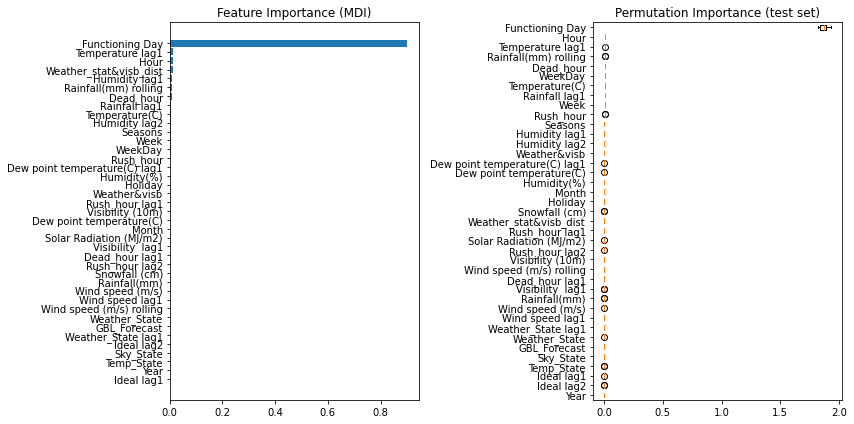

In [62]:
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
feature_names = list(X_train.columns.values)
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBR, X_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

---
## CatBoost 

In [63]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
#grid = {'depth': [4], 'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.05]} #0.42222

model = cb.CatBoostRegressor(loss_function='RMSE',random_state=9110,silent=True
                             ,bootstrap_type = 'Bernoulli' ,depth= 3
                             ,iterations= 5000, l2_leaf_reg= 1 , learning_rate= 0.04 )
#grid = {'depth': [4],'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.038]} ##0.4229364603151052
# grid = {'max_depth': [4],'iterations': [2700], 'l2_leaf_reg': [1], 'learning_rate': [0.038],'subsample': [0.85]} ##0.4229364603151052

model.fit(train_dataset)
pred_test = model.predict(X_test)
pred_train=model.predict(X_train)
# rmse= (np.sqrt(mean_squared_error(y_test, pred_test)))
# r2 = r2_score(y_test, pred_test)
print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))

(Test) CatBoost Regression RMSLE: 0.22260122142864747
(Train) CatBoost Regression RMSLE: 0.1272693245469816


Text(0.5, 0, 'CatBoost Feature Importance')

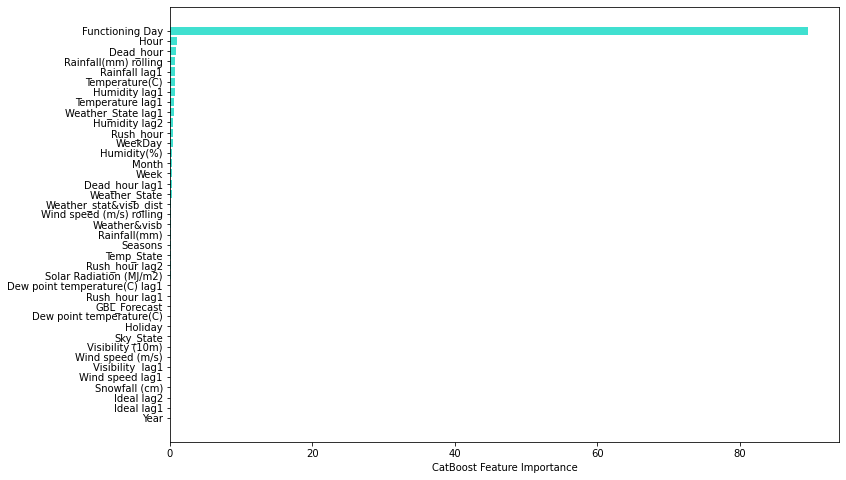

In [64]:
figure(figsize=(12,8))
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

---

### Submission Preparation

In [65]:
full_test_path = r"SeoulBikeDataTestFull.csv"

In [66]:
full_test = pd.read_csv(full_test_path)

In [67]:
test = df_test.copy()

In [68]:
test['Year'] = df_test['Date'].dt.year.astype('int')
test['Week'] = df_test['Date'].dt.isocalendar().week.astype('int')
test['Month'] = df_test['Date'].dt.month.astype('int') 
test['WeekDay'] = df_test['Date'].dt.weekday.astype('int')

In [69]:
#test.y.value_counts()

In [70]:
test.columns

Index(['ID', 'Date', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay'],
      dtype='object')

## Test Data Procc

In [71]:
map_data_series(test,'Functioning Day',['Yes','No'],[1,0])

In [72]:
map_data_series(test,'Holiday',['Holiday','No Holiday'],[1,0])

In [73]:
map_data_series(test,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [74]:
new_feature_data_series(test,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')
new_feature_data_series(test,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')

In [75]:
new_feature_data_series(test,['Hour'],day_night,'day_night')
new_feature_data_series(test,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')
new_feature_data_series(test,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [76]:
new_feature_data_series(test,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [77]:
test['Ideal'] = df_test[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [78]:
#new_feature_data_series(test,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
new_feature_data_series(test,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [79]:
new_feature_data_series(test,['Visibility (10m)'],visibility,'Visibility_cat')

In [80]:
new_feature_data_series(test,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [81]:
new_feature_data_series(test,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [82]:
test['Weather_State'] =test[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [83]:
map_data_series(test,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [84]:
test["Date_tmp"] = test['Date'].dt.to_period('M')
test = pd.merge(test, new_feature_df, on="Date_tmp", how="left")

In [85]:
new_feature_data_series(test,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [86]:
new_feature_data_series(test,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [87]:
new_feature_data_series(test,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [88]:
test['Sky_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5, axis = 1)

In [89]:
test['Temp_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [90]:
new_feature_data_series(test,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [91]:
test["Temperature lag1"] = test["Temperature(C)"].shift(+t)
test["Temperature lag1"].fillna(0, inplace=True)



test["Rainfall lag1"] = test["Rainfall(mm)"].shift(+t)
test["Rainfall lag1"].fillna(0, inplace=True)

test["Visibility  lag1"] = test["Visibility (10m)"].shift(+t)
test["Visibility  lag1"].fillna(0, inplace=True)



test["Wind speed lag1"] = test["Wind speed (m/s)"].shift(+t)
test["Wind speed lag1"].fillna(0, inplace=True)

test["Weather_State lag1"] = test["Weather_State"].shift(+t)
test["Weather_State lag1"].fillna(0, inplace=True)

test["Humidity lag1"] = test["Humidity(%)"].shift(+t)
test["Humidity lag1"].fillna(0, inplace=True)

test["Humidity lag2"] = test["Humidity(%)"].shift(+t-1)
test["Humidity lag2"].fillna(0, inplace=True)

test["Rainfall(mm) rolling"] =test["Rainfall(mm)"].rolling(2).sum()
test["Rainfall(mm) rolling"].fillna(0, inplace=True)

test["Wind speed (m/s) rolling"] =test["Weather_State"].rolling(2).sum()
test["Wind speed (m/s) rolling"].fillna(0, inplace=True)

test["Rush_hour lag1"] = test["Rush_hour"].shift(+t)
test["Rush_hour lag1"].fillna(0, inplace=True)

test["Rush_hour lag2"] = test["Rush_hour"].shift(+t-1)
test["Rush_hour lag2"].fillna(0, inplace=True)

test["Dead_hour lag1"] = test["Dead_hour"].shift(+t)
test["Dead_hour lag1"].fillna(0, inplace=True)



test["Ideal lag1"] = test["Ideal"].shift(+t)
test["Ideal lag1"].fillna(0, inplace=True)

test["Ideal lag2"] = test["Ideal"].shift(+t-1)
test["Ideal lag2"].fillna(0, inplace=True)

test["Dew point temperature(C) lag1"] = test["Dew point temperature(C)"].shift(+t)
test["Dew point temperature(C) lag1"].fillna(0, inplace=True)



In [92]:
#test.drop(["Date", "y", "Date_tmp", "Dataset"], axis=1, inplace=True)
Xtest = test[selected_features]
Xtest.columns

Index(['Hour', 'Week', 'Month', 'Year', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Dew point temperature(C)', 'Snowfall (cm)',
       'Wind speed (m/s)', 'Visibility (10m)', 'WeekDay', 'Seasons', 'Holiday',
       'Temperature(C)', 'Humidity(%)', 'Functioning Day', 'Rush_hour',
       'Dead_hour', 'Weather_State', 'Weather&visb', 'Weather_stat&visb_dist',
       'Sky_State', 'Temp_State', 'GBL_Forecast', 'Temperature lag1',
       'Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
       'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
       'Dead_hour lag1', 'Ideal lag1', 'Dew point temperature(C) lag1',
       'Humidity lag2', 'Rush_hour lag2', 'Ideal lag2', 'Rainfall(mm) rolling',
       'Wind speed (m/s) rolling'],
      dtype='object')

### model Predictions 

## XGB

In [93]:
preds_expXGB = 0
def XGB_Full_predict():
    global preds_expXGB
    Xtest = test[selected_features]

    predsXGB = XGB.predict(Xtest)
    preds_expXGB = np.round(np.exp(predsXGB))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expXGB, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expXGB) * 100,' %')
XGB_Full_predict()

(Full Test) XGB RMSLE: 0.29961532166866117
(Full Test) XGB R2 Score: 92.75006209680086  %


## GBR

In [94]:
preds_expGBR = 0
def GBR_Full_predict():
    global preds_expGBR
    Gtest = test[selected_features]

    predsGBR = GBR.predict(Gtest)
    preds_expGBR = np.round(np.exp(predsGBR))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expGBR, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expGBR) * 100,' %')
GBR_Full_predict()

(Full Test) XGB RMSLE: 0.3001818056963347
(Full Test) XGB R2 Score: 92.80752209189679  %


### CatBoost

In [95]:
preds_expCat =0 
def Catboost_Full_predict():
    global preds_expCat
    Ctest = test[selected_features]

    predsCat = model.predict(Ctest)
    preds_expCat = np.round(np.exp(predsCat))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expCat, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expCat) * 100,' %')
Catboost_Full_predict()   

(Full Test) XGB RMSLE: 0.2910929089398711
(Full Test) XGB R2 Score: 92.58956752770338  %


## Stacking 2

In [96]:
def percy(v1,v2,precision=50):
    lowest_score = 1
    lowest_percentage = 0
    for i in np.linspace(0,1,precision):
        percentage_1 = i
        percentage_2 = 1-percentage_1
        score = rmsle(full_test.y, v1*percentage_1 + v2 *percentage_2, False)
        if  score < lowest_score:
            lowest_score = score
            lowest_percentage = i
    print(f'lowest score {lowest_score} , best_percentage v1 : {lowest_percentage},v2 : {1-lowest_percentage}')
    print("(Full Test) 2stack:", r2_score(full_test.y, v1*percentage_1 + v2 *percentage_2 ) * 100,' %')
    return lowest_percentage , 1-lowest_percentage

In [97]:
def percy_3valves(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy(v1,v2,precision)
    pv1_3,pv3_1 = percy(v1,v3,precision)
    pv2_3,pv3_2 = percy(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('--------------------------------------------------------------------------------')
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [98]:
def percy_R2(v1,v2,precision=50):
    highest_score = 0
    highest_percentage = 0
    for i in np.linspace(0,1,precision):
        p1 = i
        p2 = 1-p1
        score = r2_score(full_test.y, v1*p1 + v2 *p2 )
        if  score > highest_score:
            highest_score = score
            highest_percentage = i
    print(f'highest_score {highest_score} , best_percentage v1 : {highest_percentage},v2 : {1-highest_percentage}')
    return highest_percentage , 1-highest_percentage

In [99]:
def percy_3valves_R2(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy_R2(v1,v2,precision)
    pv1_3,pv3_1 = percy_R2(v1,v3,precision)
    pv2_3,pv3_2 = percy_R2(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [100]:
percy_3valves_R2(preds_expGBR,preds_expCat,preds_expXGB,precision=50)


highest_score 0.9297670488402727 , best_percentage v1 : 0.5918367346938775,v2 : 0.40816326530612246
highest_score 0.9308019646107202 , best_percentage v1 : 0.5306122448979591,v2 : 0.4693877551020409
highest_score 0.9305312017462565 , best_percentage v1 : 0.44897959183673464,v2 : 0.5510204081632654
(Full Test) rmsle 3_stacks:  0.29173730028438993
(Full Test) 3stack: 93.14040107014893  %
best_percentage v1 : 0.37414965986394555,v2 : 0.2857142857142857,v3 :  0.3401360544217688


(0.37414965986394555, 0.2857142857142857, 0.3401360544217688)

In [101]:
p1,p2,p3=percy_3valves(preds_expGBR,preds_expCat,preds_expXGB,precision=5)

lowest score 0.28969444345800405 , best_percentage v1 : 0.25,v2 : 0.75
(Full Test) 2stack: 92.80752209189679  %
lowest score 0.29672340741351455 , best_percentage v1 : 0.5,v2 : 0.5
(Full Test) 2stack: 92.80752209189679  %
lowest score 0.28896417618319453 , best_percentage v1 : 0.75,v2 : 0.25
(Full Test) 2stack: 92.58956752770338  %
--------------------------------------------------------------------------------
(Full Test) rmsle 3_stacks:  0.28957830222025144
(Full Test) 3stack: 93.08248325134332  %
best_percentage v1 : 0.25,v2 : 0.5,v3 :  0.25


### Save Submission

In [102]:
save_to_path = r'submissionamr.csv'
#0.2893713586123351

In [103]:
p1,p2,p3

(0.25, 0.5, 0.25)

In [104]:
test['y'] =  preds_expGBR*p1 + preds_expCat*p2 + preds_expXGB*p3
test[["ID", "y"]].to_csv(save_to_path, index=False)

In [105]:
test.y

0        135.25
1        123.75
2         93.00
3         63.50
4         38.75
         ...   
2995    1027.25
2996     783.75
2997     739.75
2998     671.25
2999     285.25
Name: y, Length: 3000, dtype: float64